In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

In [2]:
from fastai.basics import *


In [28]:
def load_data(batch_size=64):
  path = untar_data(URLs.IMAGENETTE)
  dir = [x for x in path.iterdir()]
  transform = transforms.Compose(
      [transforms.Resize([224,224]),
   #    transforms.Scale(224),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]
  )
  data_train = datasets.ImageFolder(root=dir[0], transform=transform)
  train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

  data_val = datasets.ImageFolder(root=dir[1], transform=transform)
  val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size)

  return train_loader, val_loader

In [29]:
train_loader, val_loader = load_data(batch_size=64)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}


In [5]:
print(dataset_sizes)

{'train': 9469, 'val': 3925}


In [6]:
num_classes = 10
num_epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [51]:
def show_img(img, label):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.title('label: {}'.format(label))
  plt.imshow(img)

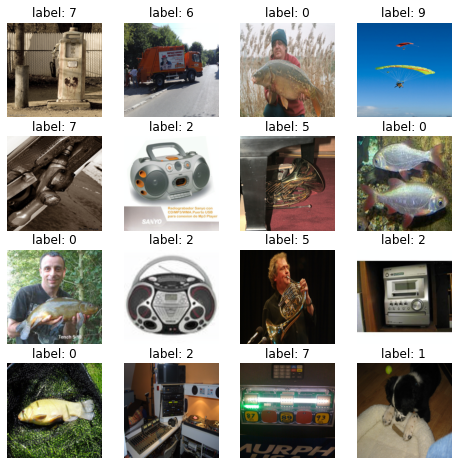

In [53]:
fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 4;
for i in range(1, columns*rows+1):
    index = np.random.randint(len(val_loader.dataset))
    img, label = val_loader.dataset[index]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    show_img(img, label)



In [31]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes):
  best_model_wts = model.state_dict()
  best_acc = 0.0

  print(model.fc)
  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inputs, labels in dataloaders[phase]:
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  
  #      print('labels: {}\n preds: {}'.format(labels, preds.data)) 
        loss = criterion(outputs, labels)
        if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(labels == preds.data)

      best_model_wts = model.state_dict()
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]
      if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

      print('{} loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    print()

  model.load_state_dict(best_model_wts)
  return model

          


In [100]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
  param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes)
resnet = resnet.to(device)


In [101]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

In [102]:
resnet10 = train_model(resnet, criterion, optimizer, dataloaders, dataset_sizes);


Linear(in_features=2048, out_features=10, bias=True)
train loss: 0.5622 Acc: 0.9153
val loss: 0.1446 Acc: 0.9870



In [45]:
def est_accuracy(model, dataloader):
  running_correct = 0
  model.eval()
  for inputs, labels in dataloader:
    inputs = Variable(inputs.to(device))
    labels = Variable(labels.to(device))
    outputs = model(inputs)
    print(outputs)
    _, preds = torch.max(outputs, 1)
    running_correct += torch.sum(labels == preds.data)
  acc = running_correct.double() / len(dataloader.dataset)
  return acc

In [38]:
torch.cuda.empty_cache()
model = models.resnet50(pretrained=True).to(device)
acc = est_accuracy(model_trained, train_loader)
print(acc)

tensor(0.9877, device='cuda:0', dtype=torch.float64)


In [129]:
logits_model = nn.Sequential(*list(deepcopy(resnet10).children())[:-1]).cuda()
last_layer = nn.Sequential(*list(deepcopy(resnet10).children())[-1:]).cuda()

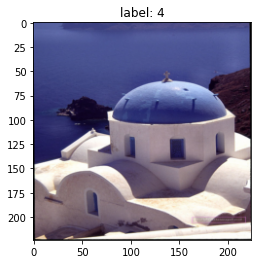

In [139]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
image1 = Variable(torch.Tensor(img1)).unsqueeze(0)
image1 = image1.to(device)
show_img(img1, label1)

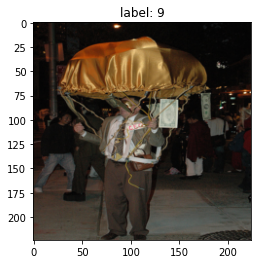

In [140]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
image2 = Variable(torch.Tensor(img2)).unsqueeze(0)
image2 = image2.to(device)
show_img(img2, label2)

In [178]:
output1 = logits_model(image1)
#output1 = torch.reshape(output1, (2048,))
probabilities1 = resnet10(image1)
_, preds1 = torch.max(probabilities1, 1)
#print(output1)

output2 = logits_model(image2)
#output2 = torch.reshape(output2, (2048,))
probabilities2 = resnet10(image2)
_, preds2 = torch.max(probabilities2, 1)
#print(output2)

output_mix = torch.cat((output1[:,:10,:,:], output2[:,10:,:,:]), dim=1)
print(output_mix.size(), output1.size())
probabilities_mix = last_layer(Variable(torch.reshape(output_mix, (2048,))))
_, preds_mix = torch.max(torch.reshape(probabilities_mix, (1,10)), 1)

print('prob1: ', probabilities1.tolist()[0])
print('prob2: ', probabilities2.tolist()[0])
print('prob mix: ', probabilities_mix.tolist())
print('Predict1: {}, predict2: {}, predict mix: {}'.format(preds1.data[0], preds2.data[0], preds_mix.data[0]))



torch.Size([1, 2048, 1, 1]) torch.Size([1, 2048, 1, 1])
prob1:  [-0.8967338800430298, -1.4491641521453857, -1.157124400138855, -0.11217810213565826, 3.8976027965545654, -0.7950393557548523, -0.25699666142463684, 0.2190207540988922, -0.32390958070755005, 0.5349023342132568]
prob2:  [-0.06416131556034088, -0.6914604902267456, -1.7851736545562744, 0.8997184038162231, -1.0820424556732178, 0.3942103683948517, 0.8379812240600586, 1.1634162664413452, -1.269824504852295, 0.770350456237793]
prob mix:  [-0.08247287571430206, -0.6978628635406494, -1.7624520063400269, 0.8876417279243469, -1.0725533962249756, 0.38770774006843567, 0.839943528175354, 1.1552808284759521, -1.2731881141662598, 0.7716148495674133]
Predict1: 4, predict2: 7, predict mix: 7
